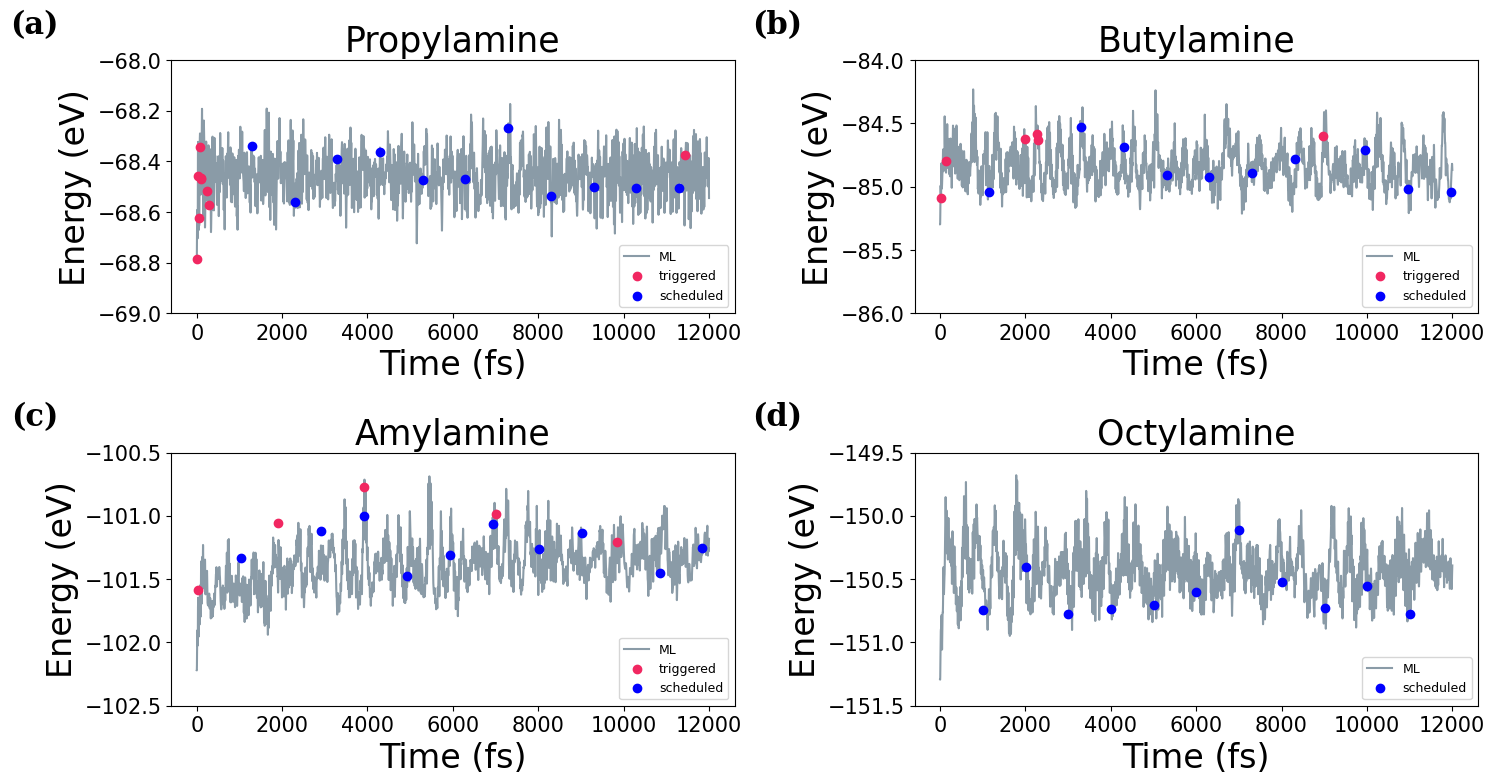

In [1]:
import datetime

def timestamp(string=None, fmt="%m/%d/%Y %H:%M:%S"):
    if string is not None:
        d = datetime.datetime.strptime(string, fmt)
    else:
        d = datetime.datetime.now()
    return d.timestamp()

def parse_logfile(file="active.log", window=(None, None)):
    start = None
    settings = []
    elapsed = []
    energies = []
    temperatures = []
    covloss = []
    exact_energies = []
    test_energies = []

    meta = []
    for line in open(file):

        if line.startswith("#"):
            continue

        s = line.split()
        ts = timestamp(" ".join(s[:2]))
        if start is None:
            start = ts
        ts = (ts - start) / 60
        split = s[2:]

        if split[1] == "settings:":
            settings = {}
            b = None
            for a in split[2:]:
                if ":" in a:
                    settings[a] = ""
                    b = a
                else:
                    settings[b] += a
            settings = {a: eval(b) for a, b in settings.items()}

        try:
            step = int(split[0])
            if window[0] and step < window[0]:
                continue
            if window[1] and step > window[1]:
                break
        except IndexError:
            continue

        elapsed += [(step, ts)]

        try:
            energies += [(step, float(split[1]))]
            temperatures += [(step, float(split[2]))]
            covloss += [(step, float(split[3]))]
        except:
            pass

        if "meta:" in split:
            meta += [(step, float(split[split.index("meta:") + 1]))]

        if "exact energy" in line:
            exact_energies += [(step, float(split[3]))]

        if "testing energy" in line:
            test_energies += [(step, float(split[3]))]

    return (
        energies,
        exact_energies,
        test_energies,

    )

def log_to_figure(
    files, titles, figsize=(15, 8), window=(None, None), meta_ax=True, plot_test=True, xlim=None, ylims=None
):
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    axs = axs.ravel()


    for i, (file, title, ax) in enumerate(zip(files, titles, axs)):
        ml, fp, test = parse_logfile(file, window=window)
        if len(ml) > 0:
            x, y = zip(*ml)
            ax.plot(x, y, color='#8A9BA7', label="ML", zorder=1)    
        if len(fp) > 0:
            r, s = zip(*fp)
            ax.scatter(r, s, color="#F12761", label="triggered", zorder=2)      
        if len(test) > 0:
            r, s = zip(*test)
            ax.scatter(r, s, color="b", label="scheduled", zorder=2)        
        ax.set_ylabel("Energy (eV)", fontsize=24)
        ax.set_xlabel("Time (fs)", fontsize=24)
        ax.tick_params(axis='both', which='major', labelsize=15)  

        if xlim:
            ax.set_xlim(xlim)      
        if ylims and ylims[i]:
            ax.set_ylim(ylims[i])
        
        ax.legend(fontsize=9, loc='lower right')
        ax.set_title(title, fontsize=25)

        letter = chr(ord('a') + i)
        ax.text(-0.2, 1.2, f'({letter})', transform=ax.transAxes, 
                fontsize=22, fontweight='bold', va='top', ha='right', fontfamily='serif')
    plt.tight_layout()

    return fig


files = [
    '../Data/Fig.2/propylamine_0/active.log',
    '../Data/Fig.2/butylamine_0/active.log',
    '../Data/Fig.2/amylamine_0/active.log',
    '../Data/Fig.2/octylamine_0/active.log'
]

titles = [
    'Propylamine',
    'Butylamine',
    'Amylamine',
    'Octylamine'
]

ylims = [
    (-69, -68.0),       # Propylamine
    (-86.0, -84.0),     # Butylamine
    (-102.5, -100.5),   # Amylamine
    (-151.5, -149.5)    # Octylamine
]

fig = log_to_figure(files=files, titles=titles, ylims=ylims)
